# Credit Card Fraud Detection

#### In this case, the goal is to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

#### It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


#### Let's upload the dataset we are working on:

In [3]:
path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Machine Learning\Ejercicios\Crédito\Kaggle"
dataset = pd.read_csv(path + "/creditcard.csv")
dataset.drop(columns="Time", inplace=True)

#### Although it's said in the case description, we will take a look at the number of fraud - non fraud transactions:

In [4]:
dataset["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Feature Engineering

#### We will analyze the distribution of each feature for both cases (fraud-non fraud) to see if the would have an impact on the prediction or not. We will drop those with similar distribution because they won't help us to predict a fraud.

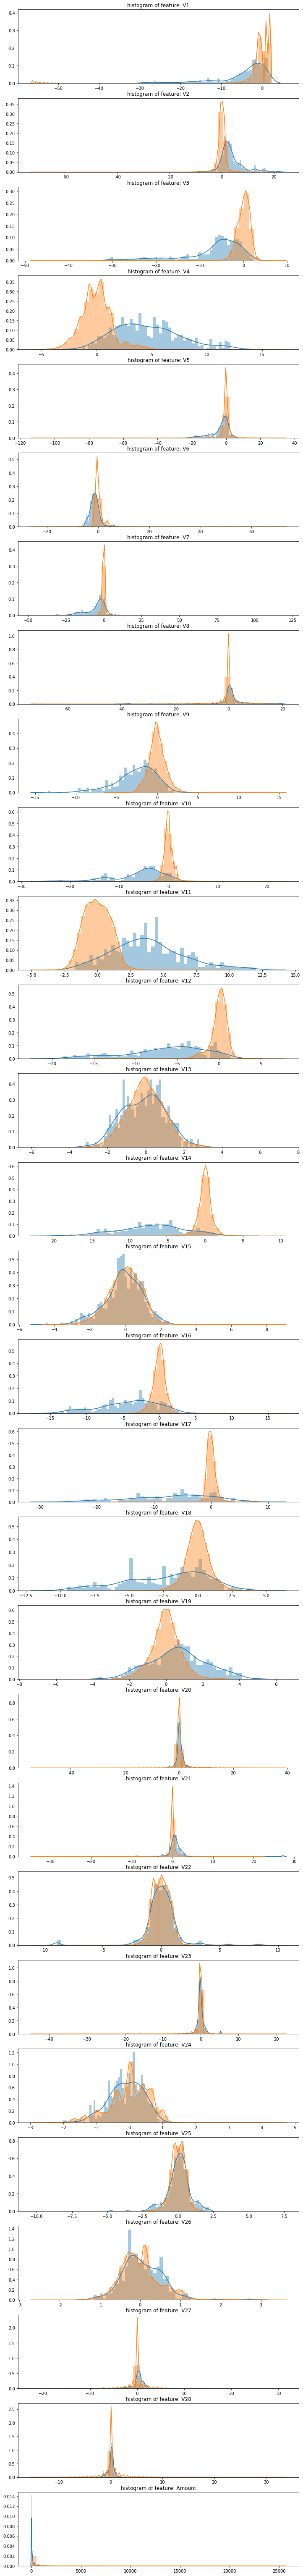

In [5]:
v_features = dataset.iloc[:, :29].columns
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(29, 1)
for i, cn in enumerate(dataset[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.Class == 1], bins=50)
    sns.distplot(dataset[cn][dataset.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

#### As explained, we drop those features with a similar distribution for the fraud - non fraud cases:

In [6]:
dataset.drop(columns=["V13", "V15", "V22", "V23", "V24", "V25", "V26"], inplace=True)

#### Next step is to normalize the dataset:

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
scaler = MinMaxScaler()
Xy = scaler.fit_transform(dataset.values)
X = Xy[:, :-1]
y = Xy[:, -1]

#### Once it's normalized, the dataset should be splitted to have data to train the model and data to test the model:

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### As we have seen at the beginning, the dataset is clearly imbalanced, so we will perform an oversampling to have a balanced dataset. If this step is not done, the model will predict always the predominant class.

In [9]:
from imblearn.over_sampling import RandomOverSampler
cc = RandomOverSampler(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

### NEURAL NETWORK

#### We will try at first with a neural network. In this case, we will use a GridSearch to use the best parameters:

In [10]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers, Sequential, optimizers

def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=10, 
                                            max_value=60, 
                                            step=10),
                               activation='relu')),
    model.add(layers.Dense(2, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [11]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld',
    overwrite=True)

In [12]:
history = tuner.search(X_resampled, y_resampled,
             epochs=5,
             #batch_size = 100,
             verbose=0,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


#### In order to know which are the chosen parameters:

In [13]:
models = tuner.get_best_models(num_models=3)
np.argmax(models[0].predict(X_test), axis=1)
import json
best_params = [json.loads(i.to_json()) for i in models]
tuner.get_best_hyperparameters(num_trials=1)[0].get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'num_layers',
    'default': None,
    'min_value': 1,
    'max_value': 2,
    'step': 1,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_0',
    'default': None,
    'min_value': 10,
    'max_value': 60,
    'step': 10,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_1',
    'default': None,
    'min_value': 10,
    'max_value': 60,
    'step': 10,
    'sampling': None}}],
 'values': {'num_layers': 2, 'units_0': 50, 'units_1': 10}}

#### Now it's time to analyze the results:

In [14]:
pred = np.argmax(models[0].predict(X_test), axis=1)
#real = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[56864,     0],
       [   98,     0]], dtype=int64)

#### Using this model we obtain 98 FN and 0 FP

### XGBOOST

#### Now we will use a XGBoost model and we will compare both results:

In [15]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 500, objective = "binary:logistic")
xgb.fit(X_resampled, y_resampled.flatten())
y_pred = xgb.predict(X_test)

#### Let's analyze the results using the confusion matrix:

In [16]:
confusion_matrix(y_test, y_pred)

array([[56861,     3],
       [   17,    81]], dtype=int64)

#### Using this model we obtain 17 FN and 3 FP

### In conclusion, we can confirm that the results obtained with both models are really different. To choose between both models we should know the cost of each FN and the cost of each FP, because in this kind of issues the impact of a FN is really high, so probably we would choose the second one, with just 17 FN.